<a href="https://colab.research.google.com/github/monavahdati/Northwind-datawarehouse/blob/master/RRN_Model_0611.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8432 - loss: 0.3546 - val_accuracy: 0.9630 - val_loss: 0.1421
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9606 - loss: 0.1464 - val_accuracy: 0.9719 - val_loss: 0.1020
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9679 - loss: 0.1063 - val_accuracy: 0.9690 - val_loss: 0.0878
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9662 - loss: 0.0932 - val_accuracy: 0.9724 - val_loss: 0.0793
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9687 - loss: 0.0836 - val_accuracy: 0.9701 - val_loss: 0.0761
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9684 - loss: 0.0759 - val_accuracy: 0.9700 - val_loss: 0.0732
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9675 - loss: 0.0763 - val_accuracy: 0.9732 - val_loss: 0.0653
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9703 - loss: 0.0673 - val_accuracy: 0.9740 - val_loss: 0

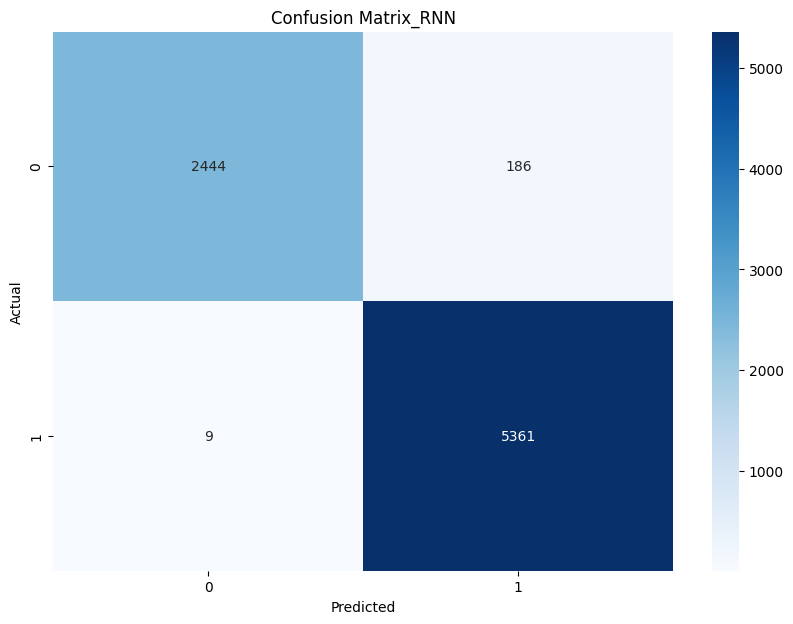

Metrics have been saved to 'model_metrics.csv'


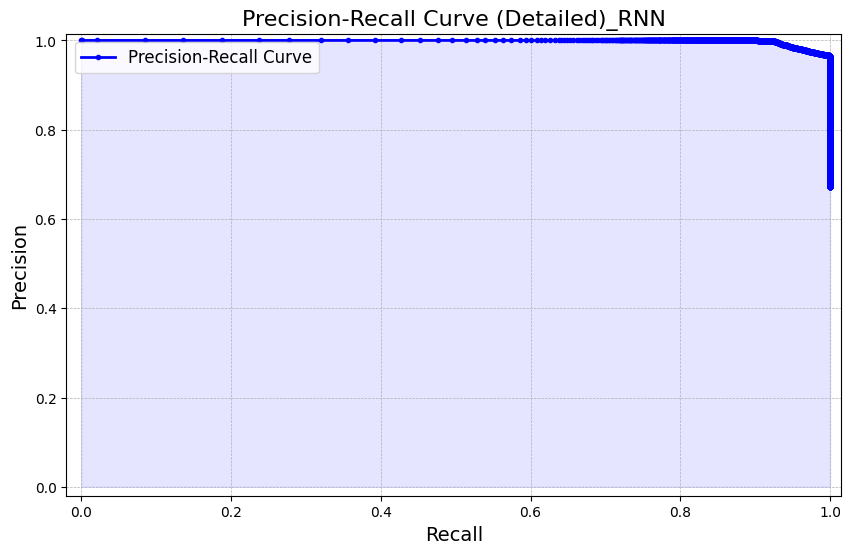

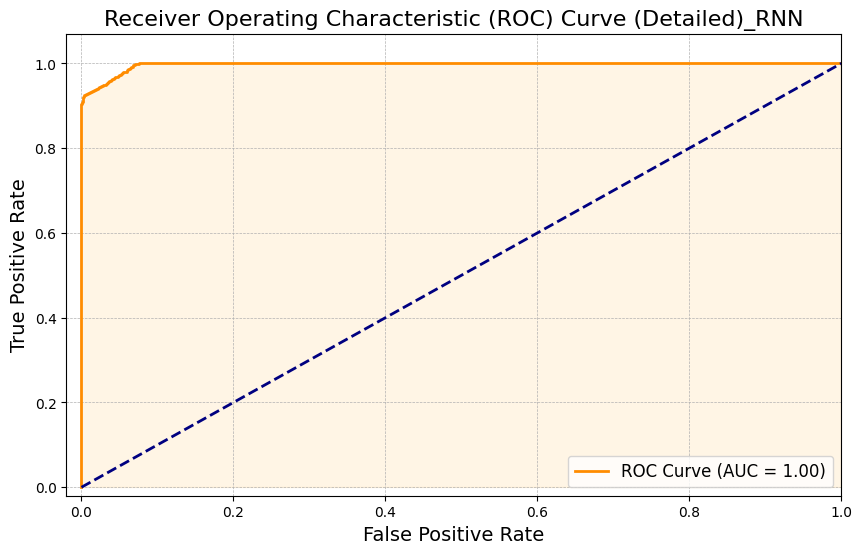

AUC-ROC: 0.9969


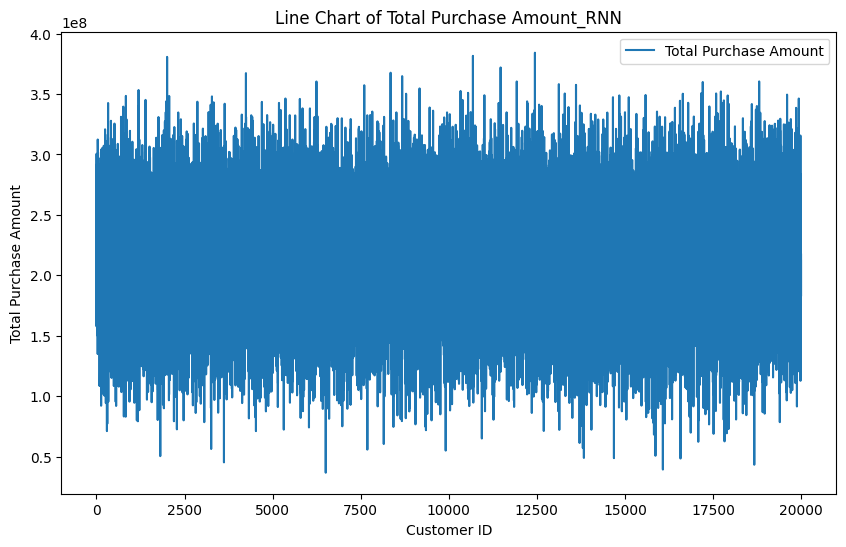

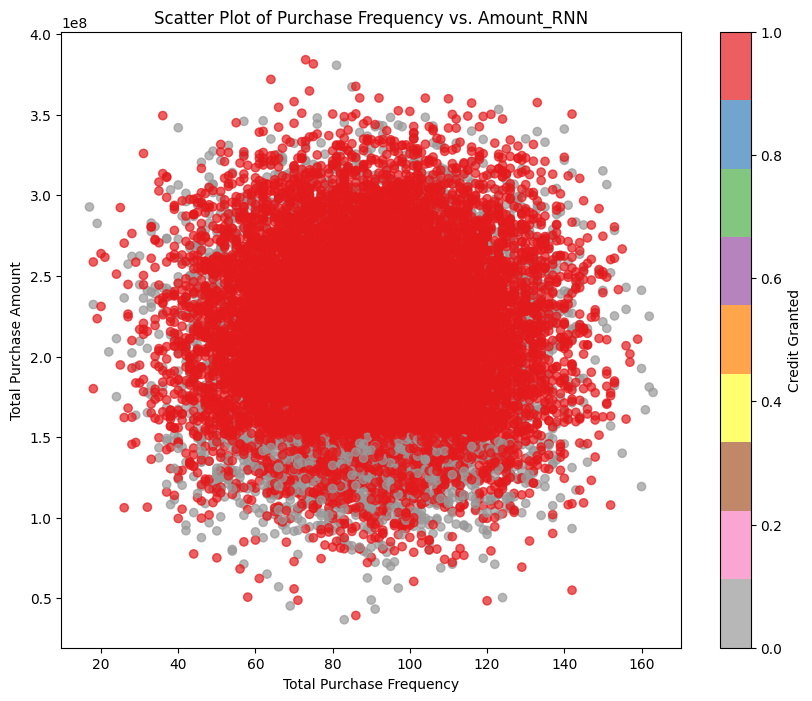

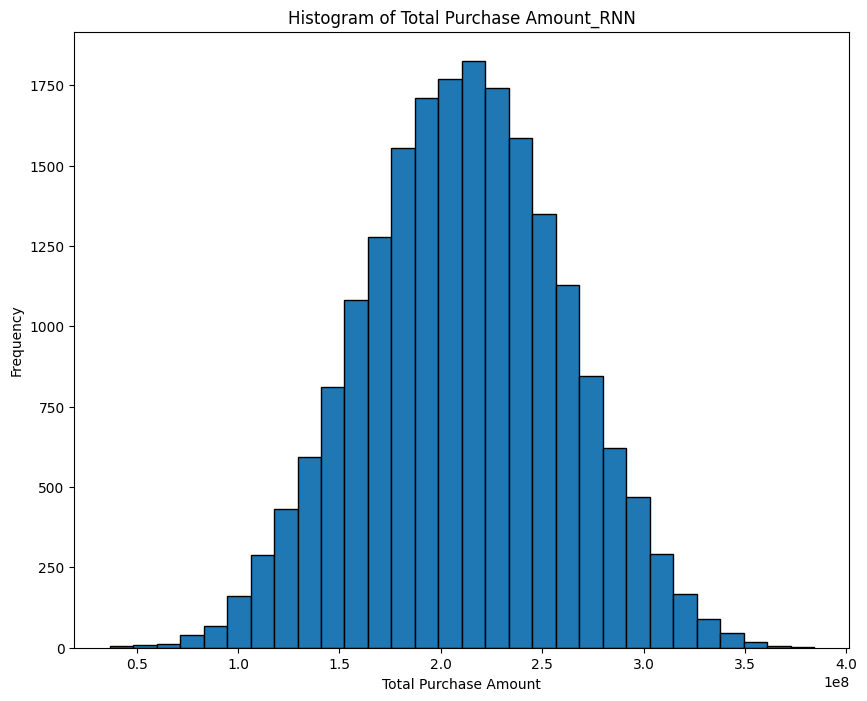

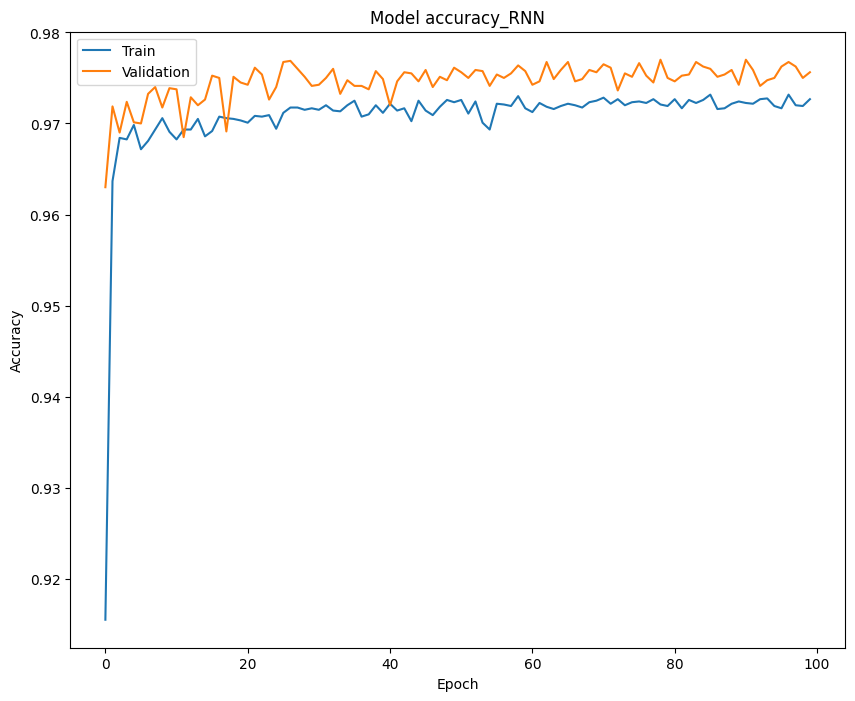

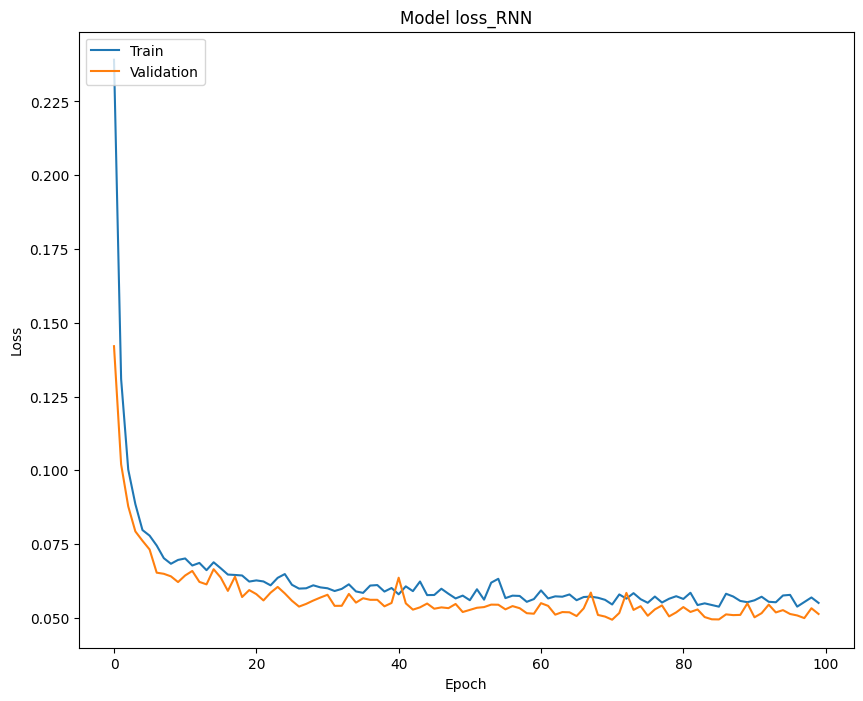

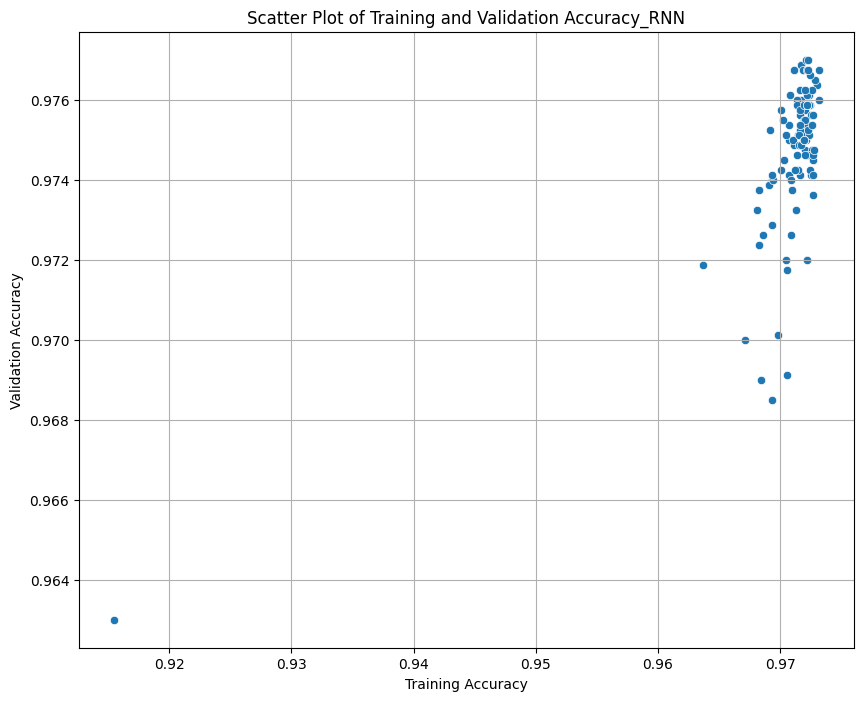

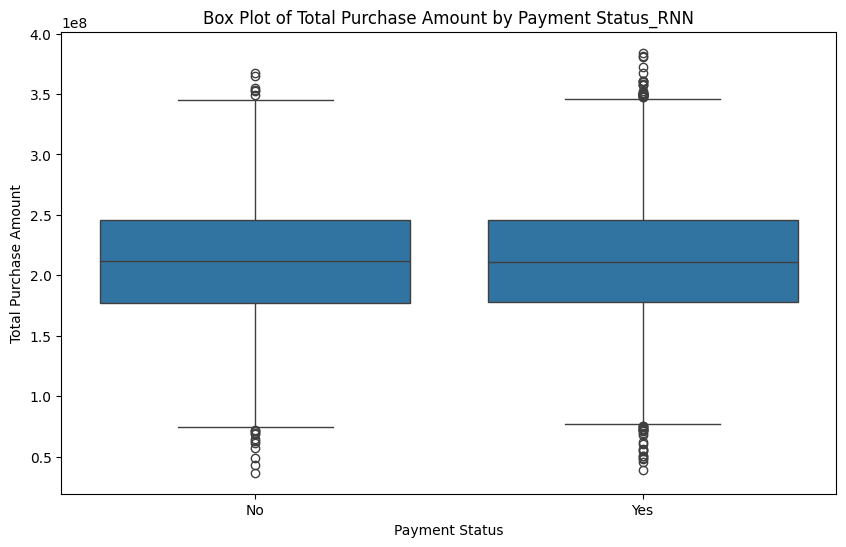

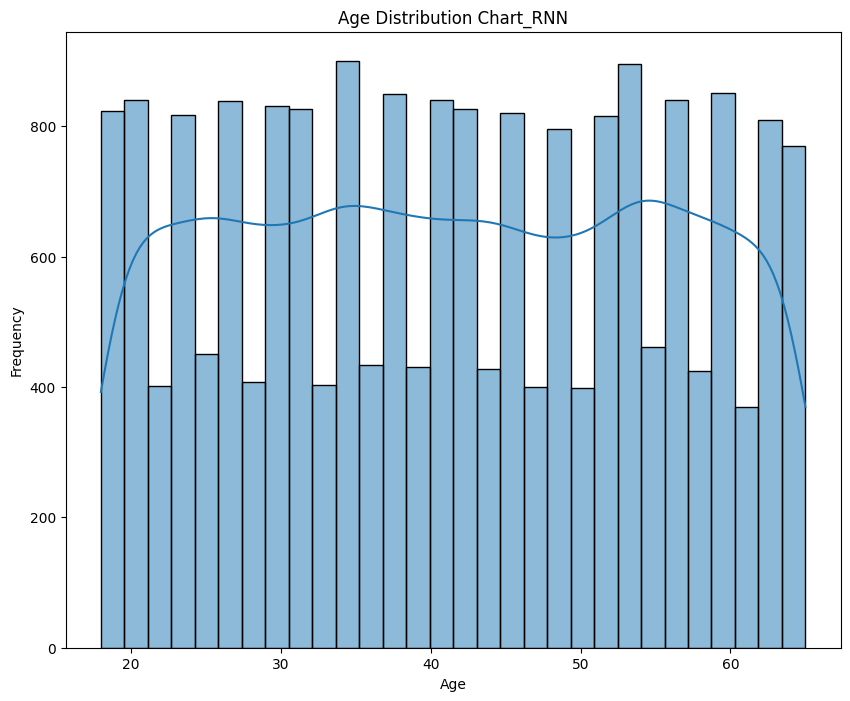

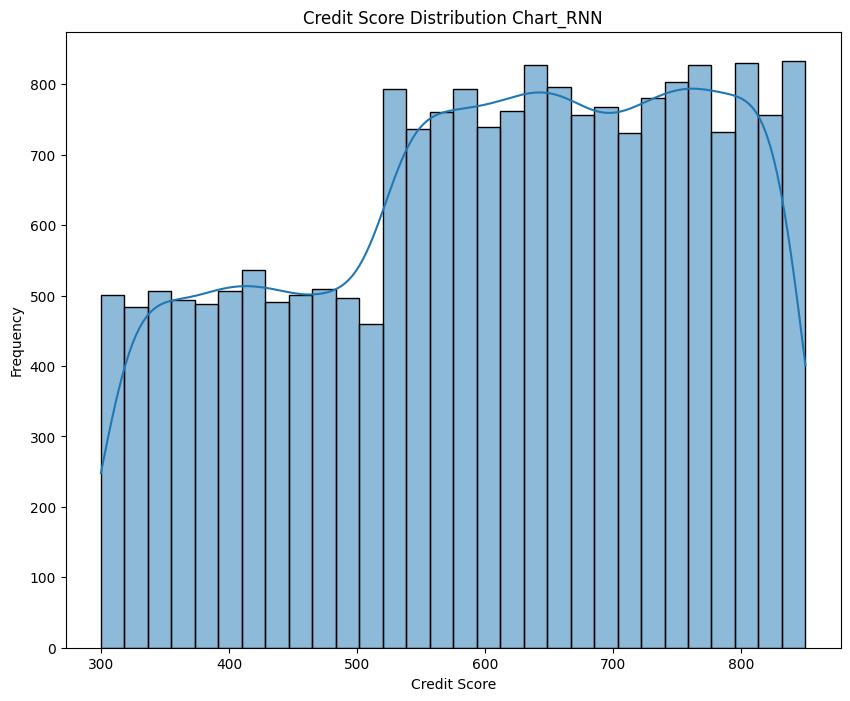

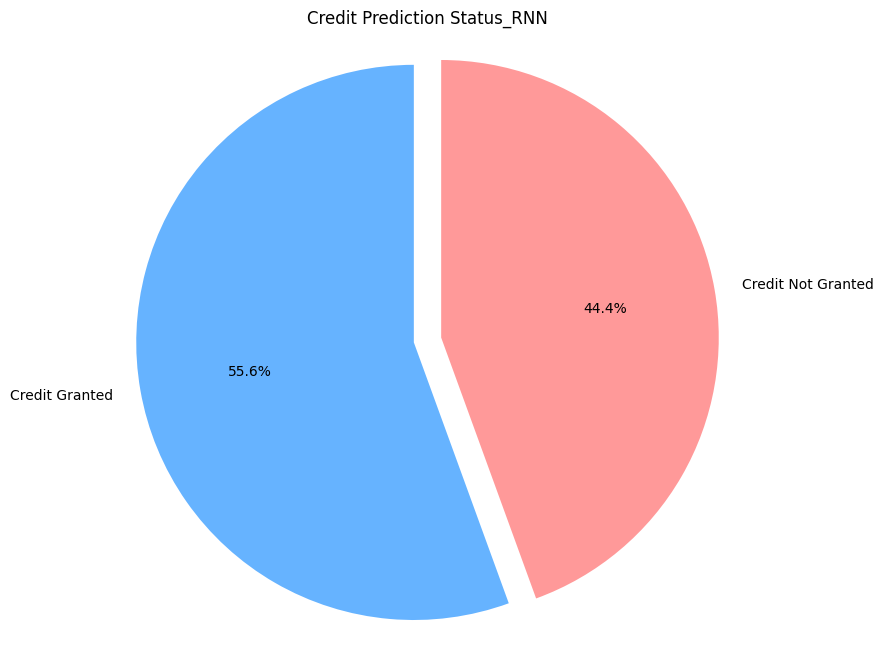

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import torch
from google.colab import files, drive

# متصل کردن Google Drive
drive.mount('/content/drive')

# بارگذاری فایل CSV
data = pd.read_csv('/content/drive/My Drive/Data/bnpl_credit_data.csv')

# Define purchase columns
purchase_freq_cols = ['Monthly Purchase Frequency 1', 'Monthly Purchase Frequency 2',
                       'Monthly Purchase Frequency 3', 'Monthly Purchase Frequency 4',
                       'Monthly Purchase Frequency 5', 'Monthly Purchase Frequency 6']

purchase_amount_cols = ['Monthly Purchase Amount 1', 'Monthly Purchase Amount 2',
                         'Monthly Purchase Amount 3', 'Monthly Purchase Amount 4',
                         'Monthly Purchase Amount 5', 'Monthly Purchase Amount 6']

# Preprocess the data
data['Age Condition'] = np.where(data['Age'] < 18, 0, 1)
data['Credit_Condition'] = np.where(data['Credit Score'] > 519, 1, 0)

# Fill NaN values with 0
data[purchase_freq_cols] = data[purchase_freq_cols].fillna(0)
data[purchase_amount_cols] = data[purchase_amount_cols].fillna(0)

# Calculate total purchases and total purchase amount
data['Total_Purchase_Frequency'] = data[purchase_freq_cols].sum(axis=1)
data['Total_Purchase_Amount'] = data[purchase_amount_cols].sum(axis=1)

# Create a new column for credit amount and repayment period based on conditions
def determine_credit(row):
    if row['Credit_Condition'] == 0:
        return 0, 0  # No credit
    if row['Payment Status'] == 'No':
        if row['Total_Purchase_Amount'] > 310000001:
            return 10000000, 1  # 10M for 1 month
        elif row['Total_Purchase_Amount'] > 150000001:
            return 5000000, 1  # 5M for 1 month
    else:
        if row['Total_Purchase_Frequency'] > 79 and row['Total_Purchase_Amount'] > 220000000:
            return 10000000, 3  # 10M for 3 months
        elif row['Total_Purchase_Frequency'] > 79 and row['Total_Purchase_Amount'] < 220000001:
            return 10000000, 1  # 10M for 1 month
        elif row['Total_Purchase_Frequency'] < 80 and row['Total_Purchase_Amount'] > 110000000:
            return 5000000, 3  # 5M for 3 months
        elif row['Total_Purchase_Frequency'] < 80 and row['Total_Purchase_Amount'] < 1100000001:
            return 5000000, 1  # 5M for 1 month
        elif row['Total_Purchase_Frequency'] < 41 and row['Total_Purchase_Amount'] < 80000001:
            return 2000000, 1  # 2M for 1 month
    return 0, 0  # Default no credit

data[['Credit Amount', 'Repayment Period']] = data.apply(determine_credit, axis=1, result_type='expand')

# Define the target column
data['Target'] = np.where(data['Credit_Condition'] & (data['Credit Amount'] > 10), 1, 0)

# Prepare features and target
features = data[['Age', 'Credit Score', 'Total_Purchase_Frequency', 'Total_Purchase_Amount', 'Age Condition']]
target = data['Target']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reshape the data for RNN
features_scaled = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.4, random_state=96)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(1, features_scaled.shape[2]), return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))  # آخرین لایه RNN
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=128)

# Predict the rankings
predictions = model.predict(X_test)
# اگر مدل شما فقط یک خروجی داشته باشد
if predictions.shape[1] == 1:
    B_predictions = predictions.flatten()  # تبدیل به یک آرایه یک بعدی
else:
    B_predictions = predictions[:, 1]  # اگر دو کلاس وجود دارد

# تبدیل پیش‌بینی‌ها به مقادیر باینری با استفاده از آستانه 0.5
threshold = 0.5
predictions = (predictions > threshold).astype(int)


# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

# محاسبه AUC-ROC
roc = roc_auc_score(y_test, predictions)
print(f'AUC-ROC: {roc:.4f}')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix_RNN')
plt.show()

# Save the metrics to a CSV file
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
    'Value': [accuracy, recall, precision, f1]
})
metrics.to_csv('model_metrics.csv', index=False)

print("Metrics have been saved to 'model_metrics.csv'")


# Calculate Precision-Recall Curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, B_predictions)


# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall Curve', color='blue', lw=2)
plt.fill_between(recall_vals, precision_vals, alpha=0.1, color='blue')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve (Detailed)_RNN', fontsize=16)
plt.xlim([-0.02, 1.015])
plt.ylim([-0.02, 1.015])
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.show()


# Assuming predictions are probabilities, not binary values
# Calculate FPR, TPR and thresholds for ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, B_predictions)
roc_auc_value = auc(fpr, tpr)

# Plot ROC Curve

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_value:.2f})')
plt.fill_between(fpr, tpr, alpha=0.1, color='orange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.00])
plt.ylim([-0.02, 1.07])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve (Detailed)_RNN', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()



# چاپ مقدار AUC-ROC
print(f'AUC-ROC: {roc_auc_value:.4f}')

# Line chart
plt.figure(figsize=(10, 6))
plt.plot(data['Customer ID'], data['Total_Purchase_Amount'], label='Total Purchase Amount')
plt.xlabel('Customer ID')
plt.ylabel('Total Purchase Amount')
plt.title('Line Chart of Total Purchase Amount_RNN')
plt.legend()
plt.show()

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(data['Total_Purchase_Frequency'], data['Total_Purchase_Amount'], c=data['Target'], cmap='Set1_r', alpha=0.7)
plt.xlabel('Total Purchase Frequency')
plt.ylabel('Total Purchase Amount')
plt.title('Scatter Plot of Purchase Frequency vs. Amount_RNN')
plt.colorbar(label='Credit Granted')
plt.show()

# Histogram
plt.figure(figsize=(10, 8))
plt.hist(data['Total_Purchase_Amount'], bins=30, edgecolor='k')
plt.xlabel('Total Purchase Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Total Purchase Amount_RNN')
plt.show()

# Extracting loss and accuracy values
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a DataFrame to hold the values
metrics_df = pd.DataFrame({
    'Epoch': range(1, len(loss) + 1),
    'Loss': loss,
    'Val_Loss': val_loss,
    'Accuracy': accuracy,
    'Val_Accuracy': val_accuracy
})

# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy_RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss_RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=metrics_df, x='Accuracy', y='Val_Accuracy')
plt.title('Scatter Plot of Training and Validation Accuracy_RNN')
plt.xlabel('Training Accuracy')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Payment Status', y='Total_Purchase_Amount', data=data)
plt.xlabel('Payment Status')
plt.ylabel('Total Purchase Amount')
plt.title('Box Plot of Total Purchase Amount by Payment Status_RNN')
plt.show()

# Age distribution chart
plt.figure(figsize=(10, 8))
sns.histplot(data['Age'], bins=30, kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution Chart_RNN')
plt.show()

# Credit score distribution chart
plt.figure(figsize=(10, 8))
sns.histplot(data['Credit Score'], bins=30, kde=True)
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Credit Score Distribution Chart_RNN')
plt.show()



# Pie chart of credit prediction status
credit_status_counts = data['Target'].value_counts()
sizes = np.array([10, 8])  # Your sizes data here
labels = ['Credit Granted', 'Credit Not Granted']  # Your labels
colors = ['#66b3ff', '#ff9999']  # Example colors
explode = (0.1, 0)  # only "explode" the 1st slice
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', explode=explode, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Credit Prediction Status_RNN')
plt.show()

# Save the results to a new CSV file
data.to_csv('customer_credit_offers_RNN.csv', index=False)

#Download File
files.download('customer_credit_offers_RNN.csv')
